<a href="https://colab.research.google.com/github/Elilora/Summarizer/blob/master/BBC_Dataset_Text_Summarization_Pretrained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this age of technological advancement, the exponential growth of information at our disposal necessitates the ability to distill lengthy texts such as documents, articles, and research papers into concise, informative summaries. This skill enables us to extract the essence of text summarization, which finds applications in news aggregation, content recommendation, search retrieval, and document summarization. These summarization techniques foster more effective communication, enhance information retrieval, aid in knowledge extraction, and ultimately improve decision-making processes.

For this project, a text summarizer using pretrained models fine-tuned is developed and trained on the BBC News Summary dataset. This endeavor harnesses the power of natural language processing and machine learning to automate the summarization process, making it more efficient and accurate. By harnessing state-of-the-art language models and customizing them to the specific demands of news content, we aspire to deliver high-quality summaries that cater to the needs of readers, researchers, and decision-makers alike

# Install Packages

In [1]:
!pip install transformers  sentencepiece  rouge rouge_score
!pip install accelerate
!pip install bert-extractive-summarizer evaluate  xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 10.6 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=2dfdf69dfb1f6bc3d7907ed33016eb80d6afa4307db81c2366707241e686afe2
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

# Imports

In [2]:
import os
import nltk
import torch
import evaluate
import datasets
from google.colab import drive
import warnings
import numpy as np
import pandas as pd
import transformers
import regex as re
import seaborn as sns
from rouge import Rouge
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from summarizer import Summarizer, TransformerSummarizer
from nltk.tokenize import sent_tokenize, word_tokenize
from datasets import load_metric, DatasetDict, Dataset
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, TrainingArguments, Trainer
from transformers import pipeline, AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, AutoModelForCausalLM

warnings.filterwarnings("ignore", category=FutureWarning)

# **Load Data**

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Set your main path and paths for articles and summaries
main_path = '/content/drive/MyDrive/Dataset/BBC News Summary'
articles_path = os.path.join(main_path, 'News Articles')
summaries_path = os.path.join(main_path, 'Summaries')
articles = []
summaries = []
categories = []

In [ ]:
def count_files(category_articles_path):
    article_paths = [file for file in os.listdir(category_articles_path) if file.endswith('.txt')]
    return article_paths

# Read and store article, summary, and category data
for category in os.listdir(articles_path):
    category_articles_path = os.path.join(articles_path, category)
    category_summaries_path = os.path.join(summaries_path, category)

    article_files = count_files(category_articles_path)

    for file in article_files:
        article_file_path = os.path.join(category_articles_path, file)
        summary_file_path = os.path.join(category_summaries_path, file)

        try:
            with open(article_file_path, "r") as article_file:
                article_text = '.'.join([line.rstrip() for line in article_file.readlines()])
                articles.append(article_text)

            with open(summary_file_path, "r") as summary_file:
                summary_text = summary_file.read()
                summaries.append(summary_text)

            categories.append(category)
        except Exception as e:
            print(f"Error processing {article_file_path} or {summary_file_path}: {str(e)}")

# Check if all arrays have the same length
if len(articles) == len(summaries) == len(categories):
     # if true create a dataframe with the arrays
    Articles_data = pd.DataFrame({'Articles': articles, 'Summaries': summaries, 'Category': categories})
else:
    print("Error: The arrays have different lengths.")

In [ ]:
pd.set_option('display.max_columns', None)

# 3. Exploratory Data Analysis

In [ ]:

Articles_data.head()

In [ ]:
Articles_data.info()

In [ ]:
Articles_data.describe()

In [ ]:
def check_missing_values(dataframe):
    # Check for missing values in the dataframe
    missing_values = dataframe.isnull().sum()
    print(missing_values)

def check_duplicates(dataframe):
    # Check for duplicates in the dataframe
    any_duplicates = dataframe.duplicated().any()
    print(f"Are there any duplicates? {any_duplicates}")

def find_and_remove_duplicates(dataframe):
    # Find and display duplicated rows
    duplicates = dataframe[dataframe.duplicated(keep=False)]
    print("Duplicated rows:")
    print(duplicates)

    # Remove duplicates
    dataframe = dataframe.drop_duplicates()

    # Check if there are any more duplicates after removal
    any_duplicates_after_removal = dataframe.duplicated().any()
    print(f"Are there any duplicates after removal? {any_duplicates_after_removal}")

    # Return the dataframe with duplicates removed
    return dataframe

print(check_missing_values(Articles_data))
print(check_duplicates(Articles_data))
print(find_and_remove_duplicates(Articles_data))

In [ ]:
Articles_data_copy = Articles_data.copy()
Articles_data_copy['Article Length'] = Articles_data_copy["Articles"].apply(lambda x: len(x.split()))
Articles_data_copy['Summary Length'] = Articles_data_copy["Summaries"].apply(lambda x: len(x.split()))
Articles_data_copy['Length Difference'] = Articles_data_copy["Article Length"] - Articles_data_copy["Summary Length"]
Articles_data_copy.head()

In [ ]:
def plot_histogram_distribution(dataframe, column_name):
    # Extract the specified column
    column_data = dataframe[column_name]

    # Create a histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(column_data, bins=30, kde=True)

    # Set labels and title
    plt.xlabel(f'{column_name} Length')
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name} Lengths')

    # Show the plot
    plt.show()

def plot_boxplot_distribution(dataframe, column_name):
    # Extract the specified column
    column_data = dataframe[column_name]

    # Create a boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(column_data)

    # Set labels and title
    plt.xlabel(f'{column_name} Length')
    plt.ylabel("Count")
    plt.title(f'Boxplot of {column_name}')

    # Calculate quartiles and whiskers
    lines = plt.gca().lines[:6]
    all_lines = [lines[i].get_ydata()[0] for i in range(5)]
    Q1, Q3, lower_whisker, upper_whisker, Q2 = all_lines
    print("Upper whisker:", upper_whisker)
    print("Q3:", Q3)
    print("Q2:", Q2)
    print("Q1:", Q1)
    print("Lower whisker:", lower_whisker)

    # Show the plot
    plt.show()

    # Return whisker values
    return upper_whisker, lower_whisker

def plot_piechart_and_table(data, column_name):
    # Count values in the specified column
    value_counts = data[column_name].value_counts()

    # Create a pie chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    ax1.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')

    # Create a table
    data_table = pd.DataFrame({'Category': value_counts.index, 'Count': value_counts.values})
    ax2.table(cellText=data_table.values, colLabels=data_table.columns, cellLoc='center', loc='center')
    ax2.axis('off')

    # Show the plots
    plt.show()

def plot_wordcloud(data, column_name):
    # Generate wordcloud
    wordcloud = WordCloud(width=800, height= 400, background_color ='white', max_words = 50).generate(' '.join(data[column_name]))

    plt.figure(figsize=(10,5))
    plt.axis('off')

    # Show the plots
    plt.imshow(wordcloud, interpolation ='bilinear')



In [ ]:
# Plot the distribution of article lengths
plot_histogram_distribution(Articles_data_copy, 'Article Length')

# Plot the distribution of summary lengths
plot_histogram_distribution(Articles_data_copy, 'Summary Length')

#Plot the distribution of difference in lengths of Articles and  their Summaries
plot_histogram_distribution(Articles_data_copy, 'Length Difference')

In [ ]:
# Plot the distribution of article lengths
article_upper_whisker, article_lower_whisker= plot_boxplot_distribution(Articles_data_copy, 'Article Length')

# Plot the distribution of summary lengths
summary_upper_whisker, summary_lower_whisker= plot_boxplot_distribution(Articles_data_copy, 'Summary Length')

In [ ]:
plot_piechart_and_table(Articles_data, 'Category')

In [ ]:
max_article_length = int(article_upper_whisker)
max_summary_length = int(summary_upper_whisker)

In [ ]:
Articles_data_copy= Articles_data_copy[(Articles_data_copy['Article Length']<= max_article_length) & (Articles_data_copy["Summary Length"]<=max_summary_length)]

In [ ]:
data = Articles_data_copy.drop(columns=["Article Length", "Summary Length", "Length Difference"])
data.reset_index(drop =True, inplace=False)
data.head()

# Text Preprocesssing

In [ ]:
def data_preprocessing(text):
      contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                              "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                              "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                              "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                              "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                              "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                              "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                              "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                              "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                              "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                              "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                              "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                              "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                              "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                              "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                              "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                              "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                              "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                              "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                              "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                              "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                              "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                              "you're": "you are", "you've": "you have"}


      # Convert text to lowercase
      text = text.lower()

      # Remove double quotes
      text = re.sub('"', '', text)

      # Split the text into words
      words = text.split()
      cleaned_words = []

      # Handle contractions
      for word in words:
          if word in contraction_map:
              cleaned_words.extend(contraction_map[word].split())
          else:
              cleaned_words.append(word)

      # Join the cleaned words back into a single text
      cleaned_text = ' '.join(cleaned_words)

      # Remove possessive 's
      cleaned_text = re.sub(r"'s\b", "", cleaned_text)

      # Remove extra spaces
      cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

      # Remove special characters except for letters, numbers, and periods
      cleaned_text = re.sub(r'[^a-zA-Z0-9.]', ' ', cleaned_text)

      return cleaned_text



In [ ]:
# Apply the preprocessing function to the 'Articles' column
data['Articles'] = data['Articles'].apply(data_preprocessing)

# Apply the preprocessing function to the 'Summaries' column
data['Summaries'] = data['Summaries'].apply(data_preprocessing)

In [ ]:
plot_wordcloud(data, 'Articles')
plot_wordcloud(data, 'Summaries')

In [ ]:
# Split the data into a training set and a testing set
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def tokenize_function(examples, tokenizer):
    model_inputs = tokenizer(examples["Articles"], truncation=True, max_length=max_article_length)
    labels = tokenizer(examples["Summaries"], truncation=True, max_length=max_summary_length)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Summarization Functions

In [ ]:
# Access the "Summaries" column from train_df and test_df
train_summaries = train_df["Summaries"]
test_summaries = test_df["Summaries"]

# Define your ROUGE metric
rouge_score = load_metric("rouge")

def base_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

def evaluate_baseline(data, metric):
    summaries = [base_summary(text) for text in data]
    return metric.compute(predictions=summaries, references=data)

# Compute ROUGE scores for the test dataset
base_score = evaluate_baseline(test_summaries, rouge_score)

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = {name: round(base_score[name].mid.fmeasure * 100, 2) for name in rouge_names}
rouge_dict

In [ ]:
def prepare_summarization_model(model_name, dataset):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    dataset = dataset.map(lambda examples: tokenize_function(examples, tokenizer), batched=True)

    # Load the GPT-2 Medium model
    if model_name == "gpt2-medium":
       model = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)
       summarizer = TransformerSummarizer(transformer_type="GPT2", transformer_model_key="gpt2-medium")
    elif model_name == "EleutherAI/gpt-neo-1.3B":
        model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B").to(device)
        summarizer = TransformerSummarizer(transformer_type="Gpt-neo", transformer_model_key="Gpt-neo")
    else:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
        summarizer = pipeline(task ="summarization", model=model, tokenizer=tokenizer)


    return summarizer, dataset,model

In [ ]:
def visualize_performance(dataset, idx, summarizer_name, generated_summary, rouge_scores):
    article = dataset["test"][idx]["Articles"]
    reference_summary = dataset["test"][idx]["Summaries"]

    print(f"Article: {article}")
    print(f"\nSummary: {reference_summary}")
    print(f"\nGenerated Summary by {summarizer_name}: {generated_summary}")
    print(f"\nROUGE Scores: {rouge_scores}")

    # Plot ROUGE scores
    plt.bar(rouge_scores.keys(), rouge_scores.values())
    plt.xlabel("ROUGE Metrics")
    plt.ylabel("ROUGE Score")
    plt.title("ROUGE Scores")
    plt.show()

In [ ]:
rouge_score = load_metric("rouge")
def print_summary(dataset, idx, summarizer_name, summarizer):

    article = dataset["test"][idx]["Articles"]
    reference_summary = dataset["test"][idx]["Summaries"]

    try:
        if summarizer_name == 'gpt2_medium_summarizer' or summarizer_name == "gpt3_summarizer":
            generated_summary = summarizer(article)
        else:
            generated_summary = summarizer(dataset["test"][idx]["Articles"])[0]["summary_text"]

            scores = rouge_score.compute(predictions=[generated_summary], references=[reference_summary])
            rounded_scores = {metric: round(scores[metric].mid.fmeasure * 100, 4) for metric in scores.keys()}
            visualize_performance(dataset, idx, summarizer_name, generated_summary, rounded_scores)

    except Exception as e:
        generated_summary = "Summary generation failed."
        rounded_scores = {"ROUGE-1": 0.0, "ROUGE-2": 0.0, "ROUGE-L": 0.0}
        visualize_performance(dataset, idx, summarizer_name, generated_summary, rounded_scores)



#Models

Map:   0%|          | 0/1716 [00:00<?, ? examples/s]

Map:   0%|          | 0/429 [00:00<?, ? examples/s]

Article: dawson set for new wasps contract..european champions wasps are set to offer matt dawson a new deal...the 31 year old world cup winning scrum half has impressed since joining the london side from northampton this summer on a one year contract. wasps coach warren gatland told the daily mirror  we have not yet offered matt a new contract but we will be doing so. i am very happy with his contribution and i think he is good enough to play for another couple of years. dawson played a vital part in england world cup win last year but has fallen out of favour with new coach andy robinson after missing a training session in september. however he hopes the new deal will help him regain his england place...rugby is still my priority and there is still a burning desire within me to play the best rugby i possibly can  he said. i know within myself  if i was given the chance i could play for england again. i know i am fit enough  i am strong enough  i am skilful enough.

Summary: european 

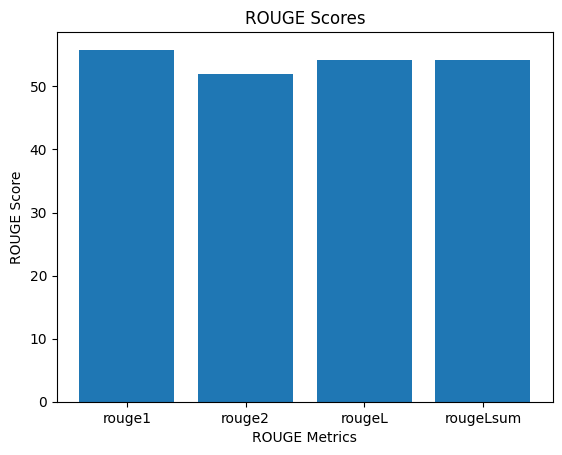

In [ ]:
bart_summarizer, bart_dataset, bart_model = prepare_summarization_model("facebook/bart-large-cnn", dataset)
print_summary(bart_dataset, 1, 'bart_summarizer',bart_summarizer)

Map:   0%|          | 0/1716 [00:00<?, ? examples/s]

Map:   0%|          | 0/429 [00:00<?, ? examples/s]

Article: dawson set for new wasps contract..european champions wasps are set to offer matt dawson a new deal...the 31 year old world cup winning scrum half has impressed since joining the london side from northampton this summer on a one year contract. wasps coach warren gatland told the daily mirror  we have not yet offered matt a new contract but we will be doing so. i am very happy with his contribution and i think he is good enough to play for another couple of years. dawson played a vital part in england world cup win last year but has fallen out of favour with new coach andy robinson after missing a training session in september. however he hopes the new deal will help him regain his england place...rugby is still my priority and there is still a burning desire within me to play the best rugby i possibly can  he said. i know within myself  if i was given the chance i could play for england again. i know i am fit enough  i am strong enough  i am skilful enough.

Summary: european 

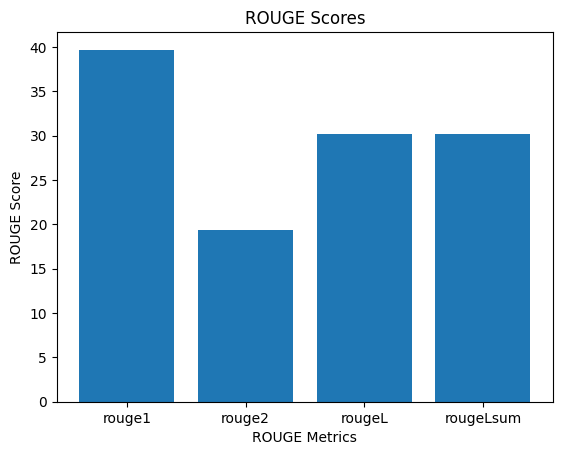

In [ ]:
bert_summarizer, bert_dataset, bert_model = prepare_summarization_model("mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization", dataset)
print_summary(bert_dataset, 1, 'bert_summarizer',bert_summarizer)

In [ ]:
gpt2_summarizer, gpt2_dataset, gpt2_model = prepare_summarization_model("gpt2-medium", dataset)
print_summary (gpt2_dataset, 1, "gpt2_medium_summarizer", gpt2_summarizer)

Map:   0%|          | 0/1716 [00:00<?, ? examples/s]

Map:   0%|          | 0/429 [00:00<?, ? examples/s]

In [ ]:
gpt3_summarizer, gpt3_dataset, gpt3_model = prepare_summarization_model("EleutherAI/gpt-neo-1.3B", dataset)
print_summary(gpt3_dataset, 1, 'gpt3_summarizer',gpt3_summarizer)

Map:   0%|          | 0/1716 [00:00<?, ? examples/s]

Map:   0%|          | 0/429 [00:00<?, ? examples/s]

# ****Fine Tuning****

In [ ]:
def evaluate_summarization(eval_pred ):
    predictions, labels = eval_pred

    model_name = "EleutherAI/gpt-neo-1.3B"
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as they cannot be decoded
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Tokenize the decoded summaries into sentences
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute ROUGE scores
    rouge = Rouge()
    result = rouge.get_scores(decoded_preds, decoded_labels, avg=True)
    #result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)


    # Round the ROUGE scores to four decimal places
    result = {k: round(v, 4) for k, v in result}

    return result


In [ ]:
# List of models to fine-tune
models_to_fine_tune = [
    #{"model_name": "google/pegasus-xsum", "model_id": "pegasus"},
    #{"model_name": "microsoft/prophetnet-large-uncased", "model_id": "prophetnet"},
    {"model_name": "mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization", "model_id": "bert"}]
    #{"model_name": "gpt2-medium", "model_id": "gpt2_medium"}]

# Define training arguments and other settings
batch_size = 2
num_train_epochs = 2

for model_info in models_to_fine_tune:
    model_name = model_info["model_name"]
    model_id = model_info["model_id"]

    # Initialize the tokenizer and model using the prepare_summarization_model function
    summarizer, dataset, model_tokenized = prepare_summarization_model(model_name)
    tokenizer = summarizer.tokenizer
    tokenizer.pad_token = tokenizer.eos_token
    model = summarizer.model

    tokenized_datsets= tokenized_datasets.remove_columns(dataset["train"].column_names)

    # Define data collator
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

    # Define training arguments
    logging_steps = len(dataset["train"]) // batch_size

    training_args = Seq2SeqTrainingArguments(output_dir=f"./model_finetuned_{model_id}",evaluation_strategy="epoch",learning_rate=5.6e-5,per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,weight_decay=0.01,save_total_limit=3,num_train_epochs=num_train_epochs,predict_with_generate=True,logging_steps=logging_steps,)

    # Initialize Trainer
    trainer = Seq2SeqTrainer(model=model,args=training_args,train_dataset=dataset["train"],eval_dataset=dataset["test"],data_collator=data_collator,
                             tokenizer=tokenizer,compute_metrics=evaluate_summarization,)


num_samples_train = len(dataset["train"])
num_samples_eval = len(dataset["test"])

print(f"Number of samples in training dataset: {num_samples_train}")
print(f"Number of samples in evaluation dataset: {num_samples_eval}")



Map:   0%|          | 0/1112 [00:00<?, ? examples/s]

ValueError: ignored

In [ ]:
for model_info in models_to_fine_tune:
    model_name = model_info["model_name"]
    model_id = model_info["model_id"] # Fine-tune the model
    trainer.train()
# Evaluate the model
    results = trainer.evaluate()

    print(f"Evaluation results for {model_id} model:")
    print(results)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
 # Save the fine-tuned model and tokenizer
model.save_pretrained("./model_finetuned")
tokenizer.save_pretrained("./model_finetuned"")
# Save the fine-tuned model
trainer.save_model("./model_finetuned")

# Use the fine-tuned model for summarization
fine_tuned_summarizer = pipeline("summarization", model="./model_finetuned", tokenizer=pegasus_tokenizer)